In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# download and store data sets



transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [3]:

# Define CNN model

import torch.nn as nn
import torch.nn.functional as F

class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CIFAR10CNN()


In [4]:

# define train and val set

from torch.utils.data import random_split

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_set, val_set = random_split(train_dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False, num_workers=2)


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

CIFAR10CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [8]:
#train model



num_epochs = 100
best_val_acc = 0
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = 100 * train_correct / train_total

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), 'cifar10_cnn_best.pth')

    print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss / train_total:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss / val_total:.4f} | Val Acc: {val_acc:.2f}%')

print(f'Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch + 1}')



Epoch 1/100 | Train Loss: 0.0076 | Train Acc: 73.32% | Val Loss: 0.0080 | Val Acc: 71.82%
Epoch 2/100 | Train Loss: 0.0075 | Train Acc: 73.35% | Val Loss: 0.0076 | Val Acc: 73.22%
Epoch 3/100 | Train Loss: 0.0074 | Train Acc: 73.94% | Val Loss: 0.0079 | Val Acc: 71.80%
Epoch 4/100 | Train Loss: 0.0073 | Train Acc: 74.46% | Val Loss: 0.0076 | Val Acc: 73.36%
Epoch 5/100 | Train Loss: 0.0072 | Train Acc: 74.76% | Val Loss: 0.0077 | Val Acc: 73.28%
Epoch 6/100 | Train Loss: 0.0071 | Train Acc: 75.06% | Val Loss: 0.0079 | Val Acc: 73.10%
Epoch 7/100 | Train Loss: 0.0071 | Train Acc: 75.14% | Val Loss: 0.0075 | Val Acc: 73.92%
Epoch 8/100 | Train Loss: 0.0070 | Train Acc: 75.65% | Val Loss: 0.0076 | Val Acc: 73.42%
Epoch 9/100 | Train Loss: 0.0069 | Train Acc: 75.65% | Val Loss: 0.0075 | Val Acc: 73.76%
Epoch 10/100 | Train Loss: 0.0068 | Train Acc: 76.07% | Val Loss: 0.0070 | Val Acc: 74.80%
Epoch 11/100 | Train Loss: 0.0067 | Train Acc: 76.27% | Val Loss: 0.0070 | Val Acc: 74.76%
Epoch 12

Epoch 92/100 | Train Loss: 0.0031 | Train Acc: 89.10% | Val Loss: 0.0056 | Val Acc: 82.00%
Epoch 93/100 | Train Loss: 0.0031 | Train Acc: 89.13% | Val Loss: 0.0061 | Val Acc: 81.10%
Epoch 94/100 | Train Loss: 0.0030 | Train Acc: 89.46% | Val Loss: 0.0059 | Val Acc: 81.32%
Epoch 95/100 | Train Loss: 0.0030 | Train Acc: 89.45% | Val Loss: 0.0059 | Val Acc: 80.68%
Epoch 96/100 | Train Loss: 0.0030 | Train Acc: 89.44% | Val Loss: 0.0059 | Val Acc: 80.88%
Epoch 97/100 | Train Loss: 0.0030 | Train Acc: 89.44% | Val Loss: 0.0059 | Val Acc: 80.98%
Epoch 98/100 | Train Loss: 0.0029 | Train Acc: 89.56% | Val Loss: 0.0059 | Val Acc: 80.66%
Epoch 99/100 | Train Loss: 0.0029 | Train Acc: 89.87% | Val Loss: 0.0057 | Val Acc: 81.60%
Epoch 100/100 | Train Loss: 0.0029 | Train Acc: 89.83% | Val Loss: 0.0059 | Val Acc: 81.14%
Best validation accuracy: 82.00% at epoch 92


In [6]:
# test model

model.load_state_dict(torch.load('cifar10_cnn_best.pth'))
model.eval()

test_loss, test_correct, test_total = 0, 0, 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = 100 * test_correct / test_total

print(f'Test Loss: {test_loss / test_total:.4f} | Test Acc: {test_acc:.2f}%')


Test Loss: 0.0061 | Test Acc: 80.15%


In [2]:
!pip install grad-cam


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38295 sha256=cbd993c0ee3112be26c00703e3e3ec79bed954450526cf809e96e806c5456971
  Stored in directory: c:\users\mainm\appdata\local\pip\cache\wheels\9b\ae\bd\221d138b169c4867b2ae5c893474d0b23bae6e4750bc95bc55
Successfully built grad-cam


In [25]:
!pip install captum


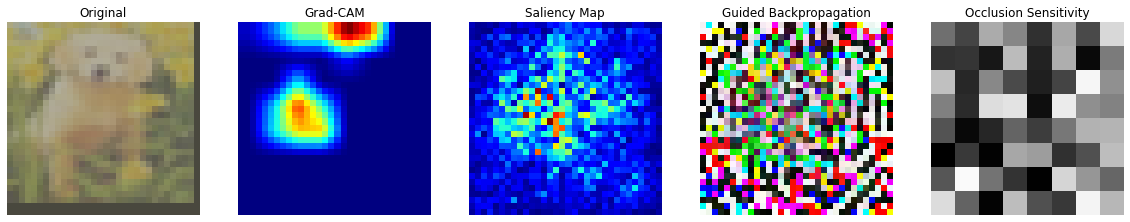

In [8]:

#visualize the images

import cv2
import numpy as np
import matplotlib.pyplot as plt

from torchvision.utils import make_grid
from gradcam.utils import visualize_cam
from gradcam import GradCAM
from torch.autograd import Variable
from captum.attr import GuidedBackprop, Occlusion

def apply_gradcam(model, input_tensor, target_layer):
    gradcam = GradCAM(model, target_layer)
    mask, _ = gradcam(input_tensor)
    heatmap, result = visualize_cam(mask, input_tensor)
    return heatmap, result

def compute_saliency_map(model, input_tensor):
    input_tensor = Variable(input_tensor, requires_grad=True)
    output = model(input_tensor)
    output_idx = output.argmax()
    output_max = output[0, output_idx]
    output_max.backward()
    saliency = input_tensor.grad.data.abs().squeeze().numpy()
    saliency = np.max(saliency, axis=0)
    return saliency

# Load trained model
model = CIFAR10CNN()
model.load_state_dict(torch.load('cifar10_cnn_best.pth'))
model.eval()

# Choose an image from the test set
test_img, test_label = test_dataset[190]
input_tensor = test_img.unsqueeze(0).to(device)

# Get the target index (class) from the model prediction
logits = model(input_tensor)
target_index = torch.argmax(logits, dim=1).item()

# Apply Grad-CAM
target_layer = model.conv3
gradcam_heatmap, gradcam_result = apply_gradcam(model, input_tensor, target_layer)

# Compute Saliency Map
saliency_map = compute_saliency_map(model, input_tensor)

# Apply Guided Backpropagation
guided_bp = GuidedBackprop(model)
guided_bp_result = guided_bp.attribute(input_tensor, target=target_index)

# Apply Occlusion Sensitivity
occlusion = Occlusion(model)
occlusion_result = occlusion.attribute(input_tensor, target=target_index, sliding_window_shapes=(3, 8, 8), strides=(3, 4, 4))

def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Unnormalize the test image
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])
unnormalized_test_img = unnormalize(test_img.clone(), mean, std)

result_images = [
    np.transpose(unnormalized_test_img.numpy(), (1, 2, 0)),
    np.transpose(gradcam_heatmap.numpy(), (1, 2, 0)),
    saliency_map,
    np.transpose(guided_bp_result.squeeze().numpy(), (1, 2, 0)),
    np.transpose(occlusion_result.squeeze().numpy(), (1, 2, 0))
]

# Convert the range of the heatmaps and results to [0, 255] for visualization
result_images = [np.uint8(255 * img) for img in result_images]

titles = ['Original', 'Grad-CAM', 'Saliency Map', 'Guided Backpropagation', 'Occlusion Sensitivity']

fig, axes = plt.subplots(1, len(result_images), figsize=(20, 5))
for i, (img, title) in enumerate(zip(result_images, titles)):
    axes[i].imshow(img, cmap='jet' if title == 'Saliency Map' else None)
    axes[i].set_title(title)
    axes[i].axis('off')
plt.show()


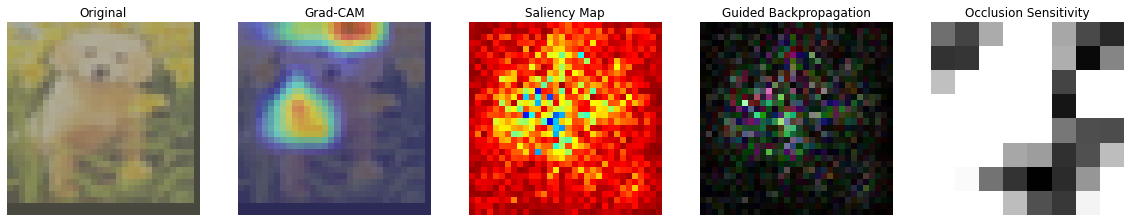

In [9]:
# Unnormalize the test image
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Convert tensor to numpy array
def tensor_to_np(tensor):
    if isinstance(tensor, np.ndarray):
        return tensor
    img = np.transpose(tensor.cpu().numpy(), (1, 2, 0))
    img = np.clip(img, 0, 1)  # Clip the values to the valid range
    return img



# Overlay heatmap on the original image
def overlay_heatmap(image, heatmap):
    return cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)

mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])

unnormalized_test_img = unnormalize(test_img.clone(), mean, std)

# Visualizations
gradcam_result_np = tensor_to_np(overlay_heatmap(tensor_to_np(unnormalized_test_img), tensor_to_np(gradcam_heatmap)))
saliency_map_np = cv2.applyColorMap(np.uint8(255 * saliency_map), cv2.COLORMAP_JET)
guided_bp_np = tensor_to_np(torch.abs(guided_bp_result[0]))
occlusion_result_np = tensor_to_np(torch.abs(occlusion_result[0]))

result_images = [
    np.transpose(unnormalized_test_img.numpy(), (1, 2, 0)),
    gradcam_result_np,
    saliency_map_np,
    guided_bp_np,
    occlusion_result_np
]

titles = ['Original', 'Grad-CAM', 'Saliency Map', 'Guided Backpropagation', 'Occlusion Sensitivity']

fig, axes = plt.subplots(1, len(result_images), figsize=(20, 5))
for i, (img, title) in enumerate(zip(result_images, titles)):
    axes[i].imshow(img, cmap='jet' if title == 'Saliency Map' else None)
    axes[i].set_title(title)
    axes[i].axis('off')
plt.show()